# Likelihood for Restaurant Business Success (in New York vs. in Toronto)

## Business Problem
I am a Data-Analyst and aspirational chef living in Manhattan, NewYork.
I am considering to open a small restaurant in the city to slowly escape corporate world. :p

I cannot afford to fail as I am putting all my life saving into the business.
To minimize the risk, I am going to explore the likelihood of success, using my newly acquired skillset of Data Science!

## Key Metric
We are going to observe and compare two data features, 
1. Identify what are the most popular restaurants in Manhattan, New York
2. Identify the alternatives in another neighbourhoods

## Data Source
1. The neighbourhoods data of New York (stored in the IBM Cloud) containing the lat,long, of the neighbourhoods
2. Four Square API to get the list of restaurants in the neighbourhoods

## Strategy and Conclusion
Looking at the data exploration explained in the Notebook below, we can look at two strategy:
1. Implementing a Blue Ocean strategy to open an unpopular restaurant type (in which I am specialized). We are going to open Malay/Indonesian Food Restaurant. Within 5 Boroughs, there is little to none of this type of restaurant
2. Implementing a Red Ocean Strategy to open a popular restaurant type (in which I am able to cook) that is either Chinese or Italian Restaurant in an ALREADY popular area; e.g. Chinese Restaurant at Chinatown, Manhattan.

## Notebook

### Library Import
First we install all the necessary libraries, including Folium

In [24]:
import requests
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
!pip install folium
import folium

     |████████████████████████████████| 94 kB 4.8 MB/s  eta 0:00:01


In [39]:
!pip install geopy
from geopy.geocoders import Nominatim

### Getting the New York Neighbourhoods Location data

In [6]:
# Getting the NY Neighborhoods Data
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')


Data downloaded!


In [7]:
with open('newyork_data.json') as json_data:
    ny_raw_json = json.load(json_data)['features']
    
ny_raw_df = pd.json_normalize(ny_raw_json)

ny= pd.DataFrame()
ny['n_borough'] = ny_raw_df['properties.borough']
ny['n_name'] = ny_raw_df['properties.name']
ny['geo'] = ny_raw_df['geometry.coordinates'].tolist()
ny['n_lat'] = ny['geo'].apply(pd.Series)[1]
ny['n_lng'] = ny['geo'].apply(pd.Series)[0]

ny.drop('geo', inplace=True, axis=1)

In [8]:
ny.head()

,n_borough,n_name,n_lat,n_lng
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Setting up Foursquare API Credentials

In [35]:
CLIENT_ID = 'ZXS0BOYVWJQT3YRTHAITRZRSLP4FBRGAQBXD5YIGAQNDBUOQ'
CLIENT_SECRET = 'DW0RFFPPAZFDRL3NQR1DTYL0VNOYS4ZK5GOBML2CXSUXEJT2'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

radius = 500

### Using Foursquare API Getting all the Restaurants in the Neighbourhoods of Manhattan

In [41]:
### Getting the Lat Long of Manhattan
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
manhattan_lat = location.latitude
manhattan_lng = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(manhattan_lat, manhattan_lng))

manhattan_data = ny[ny['n_borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


,n_borough,n_name,n_lat,n_lng
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [69]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    # Filter Only the Restaurant under Venue Category
    nearby_restaurant = nearby_venues[nearby_venues['Venue Category'].str.contains('Restaurant')]
    
    return(nearby_restaurant)

In [12]:
manhattan_venues = getNearbyVenues(names=manhattan_data['n_name'],
                                   latitudes=manhattan_data['n_lat'],
                                   longitudes=manhattan_data['n_lng']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [15]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

#filter only the restaurant column
manhattan_onehot = manhattan_onehot.filter(regex='Restaurant')

#sum all columns
manhattan_onehot['total'] = manhattan_onehot.sum(axis=1)
manhattan_onehot = manhattan_onehot[manhattan_onehot['total']>0]

# add neighborhood column back to dataframe
manhattan_onehot['name'] = manhattan_venues['Neighborhood']

manhattan_onehot.drop('total', axis=1, inplace=True)

# move neighborhood column to the first column
fixed_columns = list(manhattan_onehot.columns[-1:]) + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,name,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,...,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
12,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,Marble Hill,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,Chinatown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,Chinatown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,Chinatown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
manhattan_rest = manhattan_onehot.groupby('name').sum().reset_index()
manhattan_rest.set_index('name', inplace=True)

### Checkpoint 1 - Blue Ocean Strategy - Visualize and Analyze

In [22]:
### Sort the Values such that 
### the most popular restaurants are on the leftmost column
### the neighbourhoods with the least number of restaurant are at the bottom
manhattan_rest = manhattan_rest[manhattan_rest.sum().sort_values(ascending = False).index]



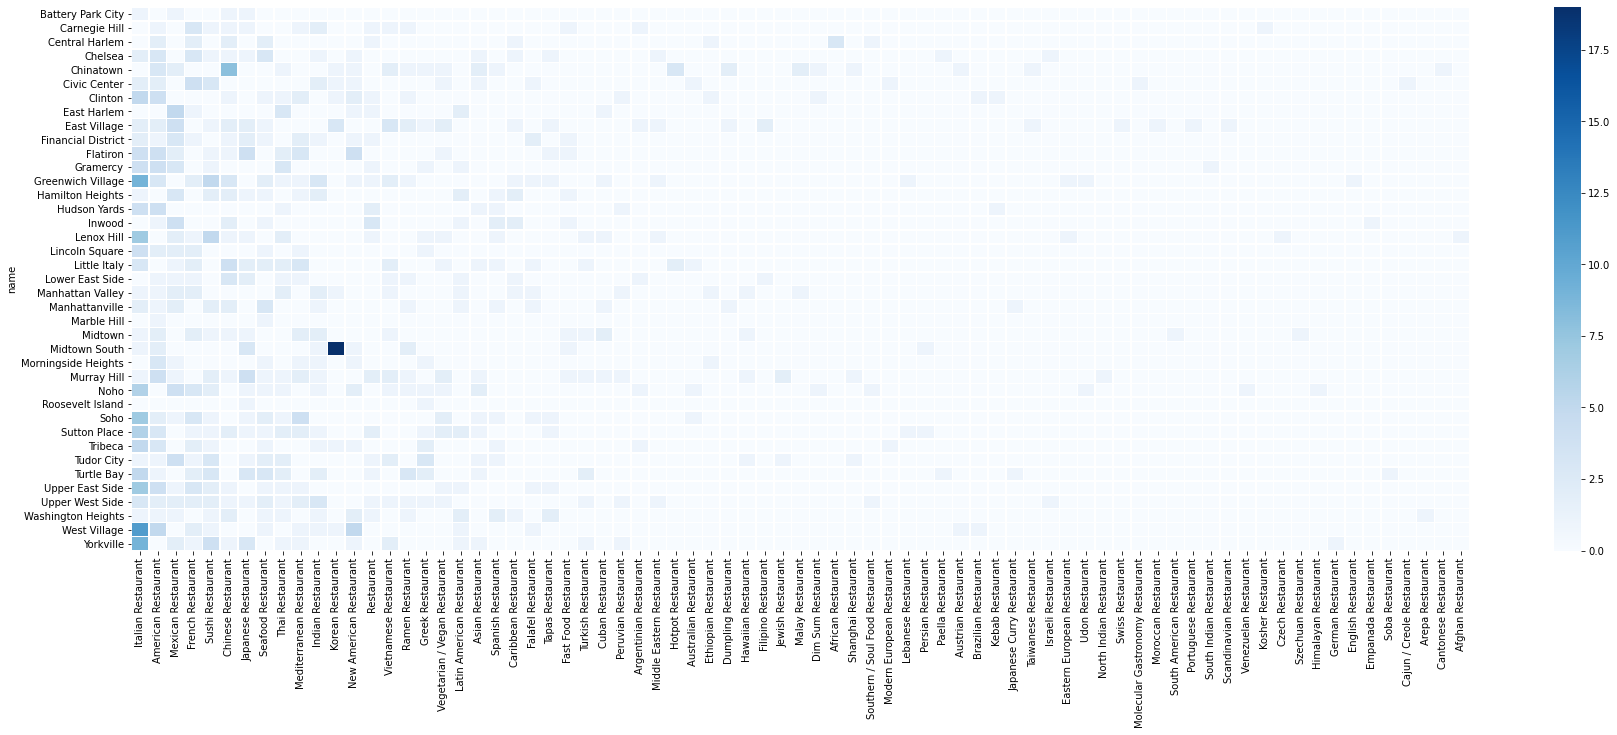

In [34]:
fig, ax = plt.subplots(figsize=(30,10))         # Sample figsize in inches

sns.heatmap(manhattan_rest,cmap="Blues", linewidths=0.5)

Few things that we can observer from the above chart:
1. Opening Korean Restaurant in Midtown South OR Chinese Restaurant in  will be very Challenging
2. Opening Italian Restaurant in any neighbourhoods is challenging in general as it is very popular.

Looking at the chart above, looks like there aren't many Malay/Indonesian Restaurant in Manhattan. 
I am good at cooking Indonesian food! This could be an opportunity
Let's also do the same with other Boroughs and see if there is similar opportunities.

### Using Foursquare API to explore other boroughs

In [67]:
def explore_borough(neighbourhoods, latitudes, longitudes):
    # Get the Foursquare Venues dataset
    df_venues = getNearbyVenues(neighbourhoods, latitudes, longitudes)
    
    # one hot encoding
    df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

    #sum all columns
    df_onehot['total'] = df_onehot.sum(axis=1)
    df_onehot = df_onehot[df_onehot['total']>0]

    # add neighborhood column back to dataframe
    df_onehot['name'] = df_venues['Neighborhood']

    df_onehot.drop('total', axis=1, inplace=True)

    # move neighborhood column to the first column
    fixed_columns = list(df_onehot.columns[-1:]) + list(df_onehot.columns[:-1])
    df_onehot = df_onehot[fixed_columns]

    # summarize the Neighbourhoods
    df_rest = df_onehot.groupby('name').sum().reset_index()
    df_rest.set_index('name', inplace=True)
    
    df_rest = df_rest[df_rest.sum().sort_values(ascending = False).index]
    
    return(df_rest, df_venues)

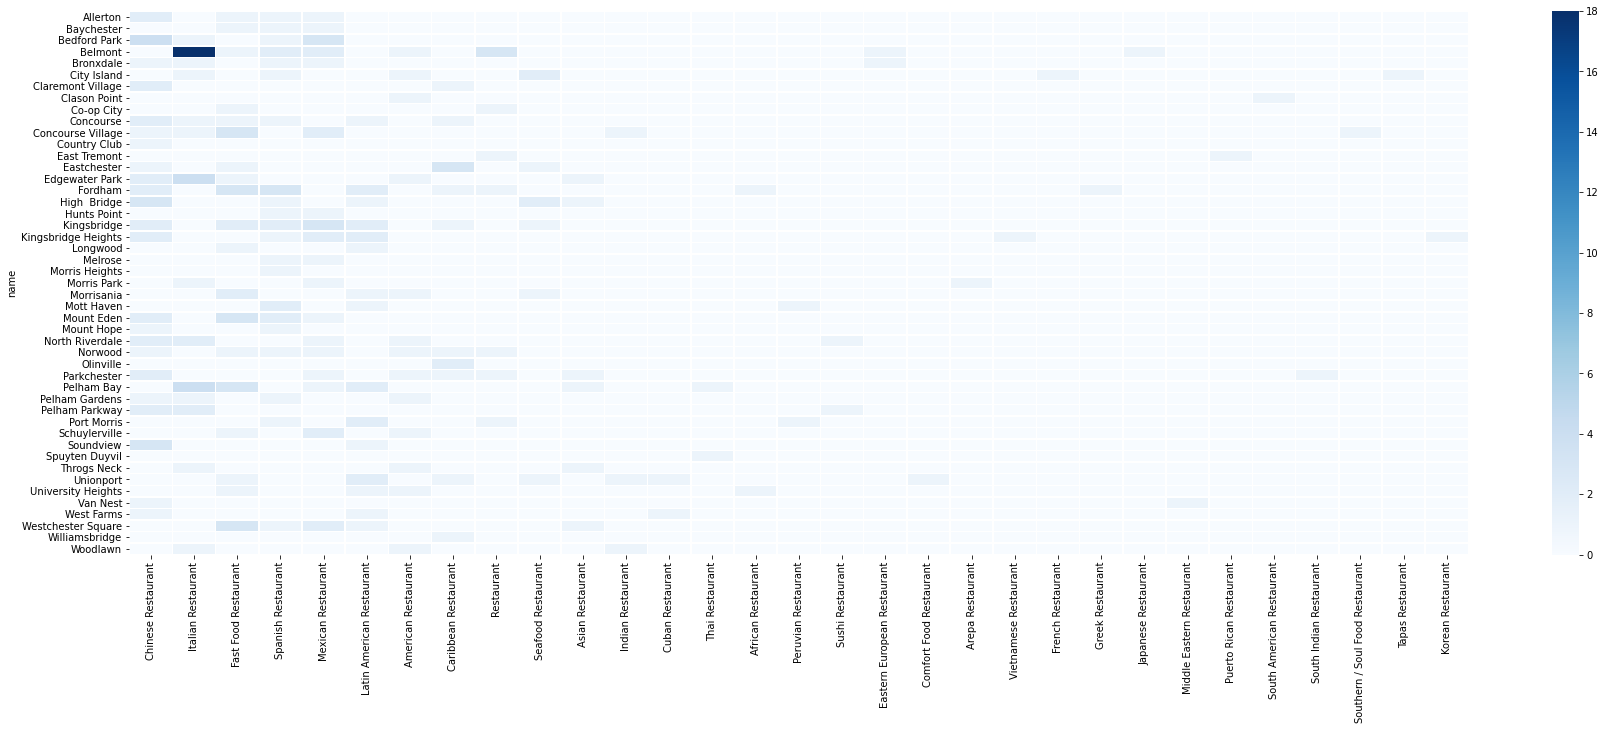

In [56]:
### Explore Bronx
bronx_data = ny[ny['n_borough'] == 'Bronx'].reset_index(drop=True)
bronx_rest, bronx_venues = explore_borough(bronx_data['n_name'], bronx_data['n_lat'],bronx_data['n_long'])

fig, ax = plt.subplots(figsize=(30,10))         # Sample figsize in inches
sns.heatmap(bronx_rest,cmap="Blues", linewidths=0.5)

In [77]:
### Explore Brooklyn
brooklyn_data = ny[ny['n_borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_rest = explore_borough(brooklyn_data['n_name'], brooklyn_data['n_lat'],brooklyn_data['n_lng'])

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island


KeyError: 'groups'

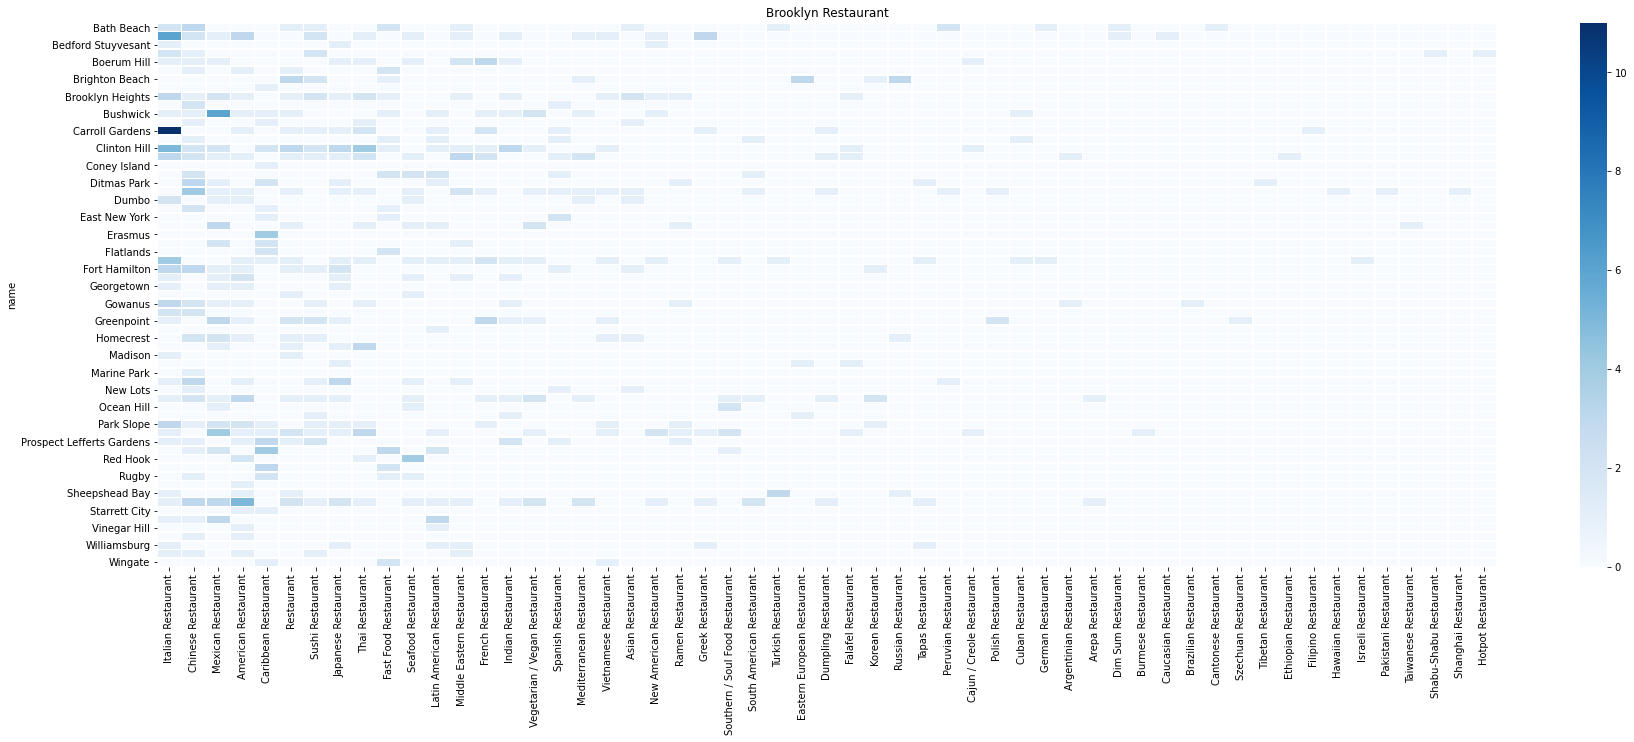

In [78]:
fig, ax = plt.subplots(figsize=(30,10))
ax.set_title('Brooklyn Restaurant')
sns.heatmap(brooklyn_rest,cmap="Blues", linewidths=0.5)

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


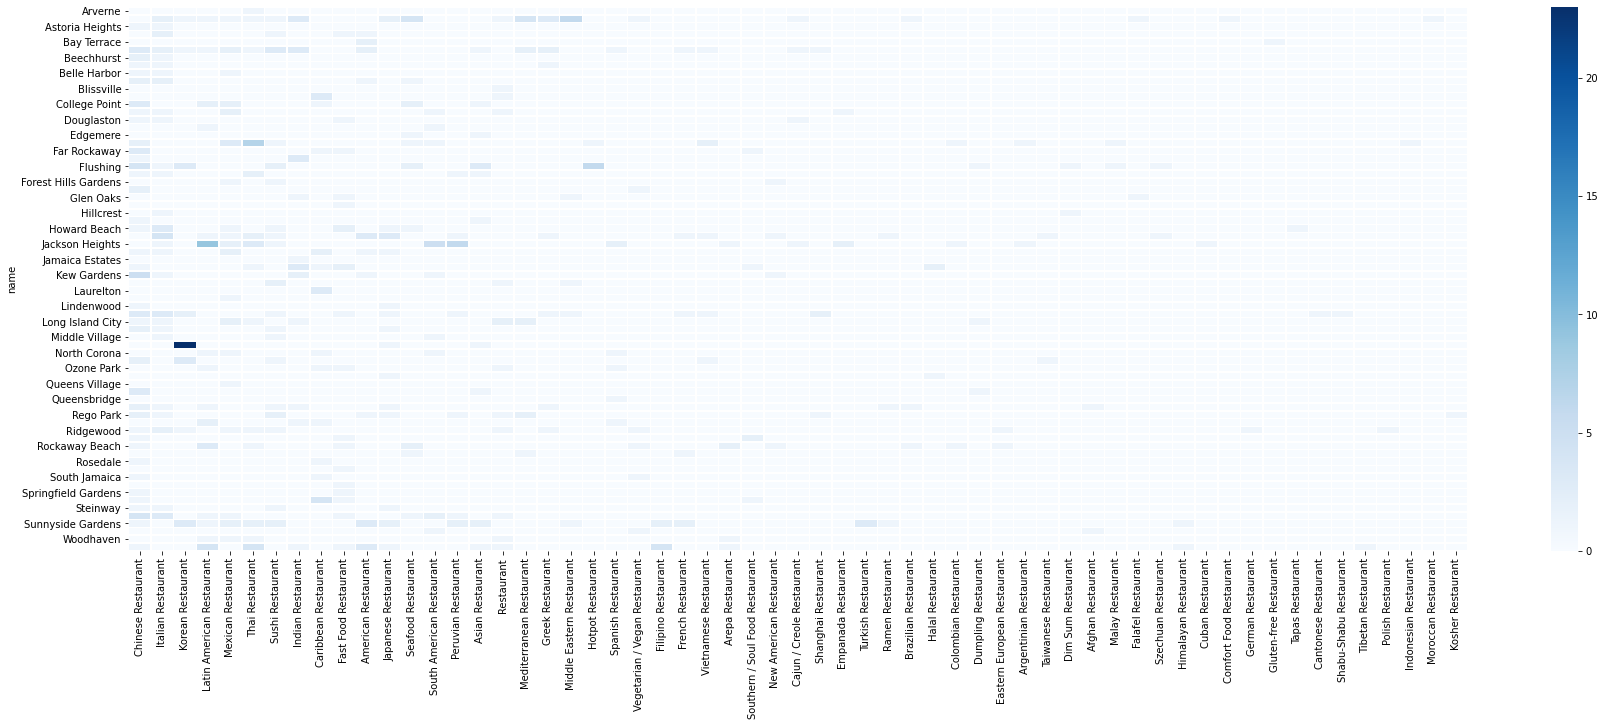

In [70]:
### Explore Queens
queens_data = ny[ny['n_borough'] == 'Queens'].reset_index(drop=True)
queens_rest, queens_venues = explore_borough(queens_data['n_name'], queens_data['n_lat'], queens_data['n_lng'])

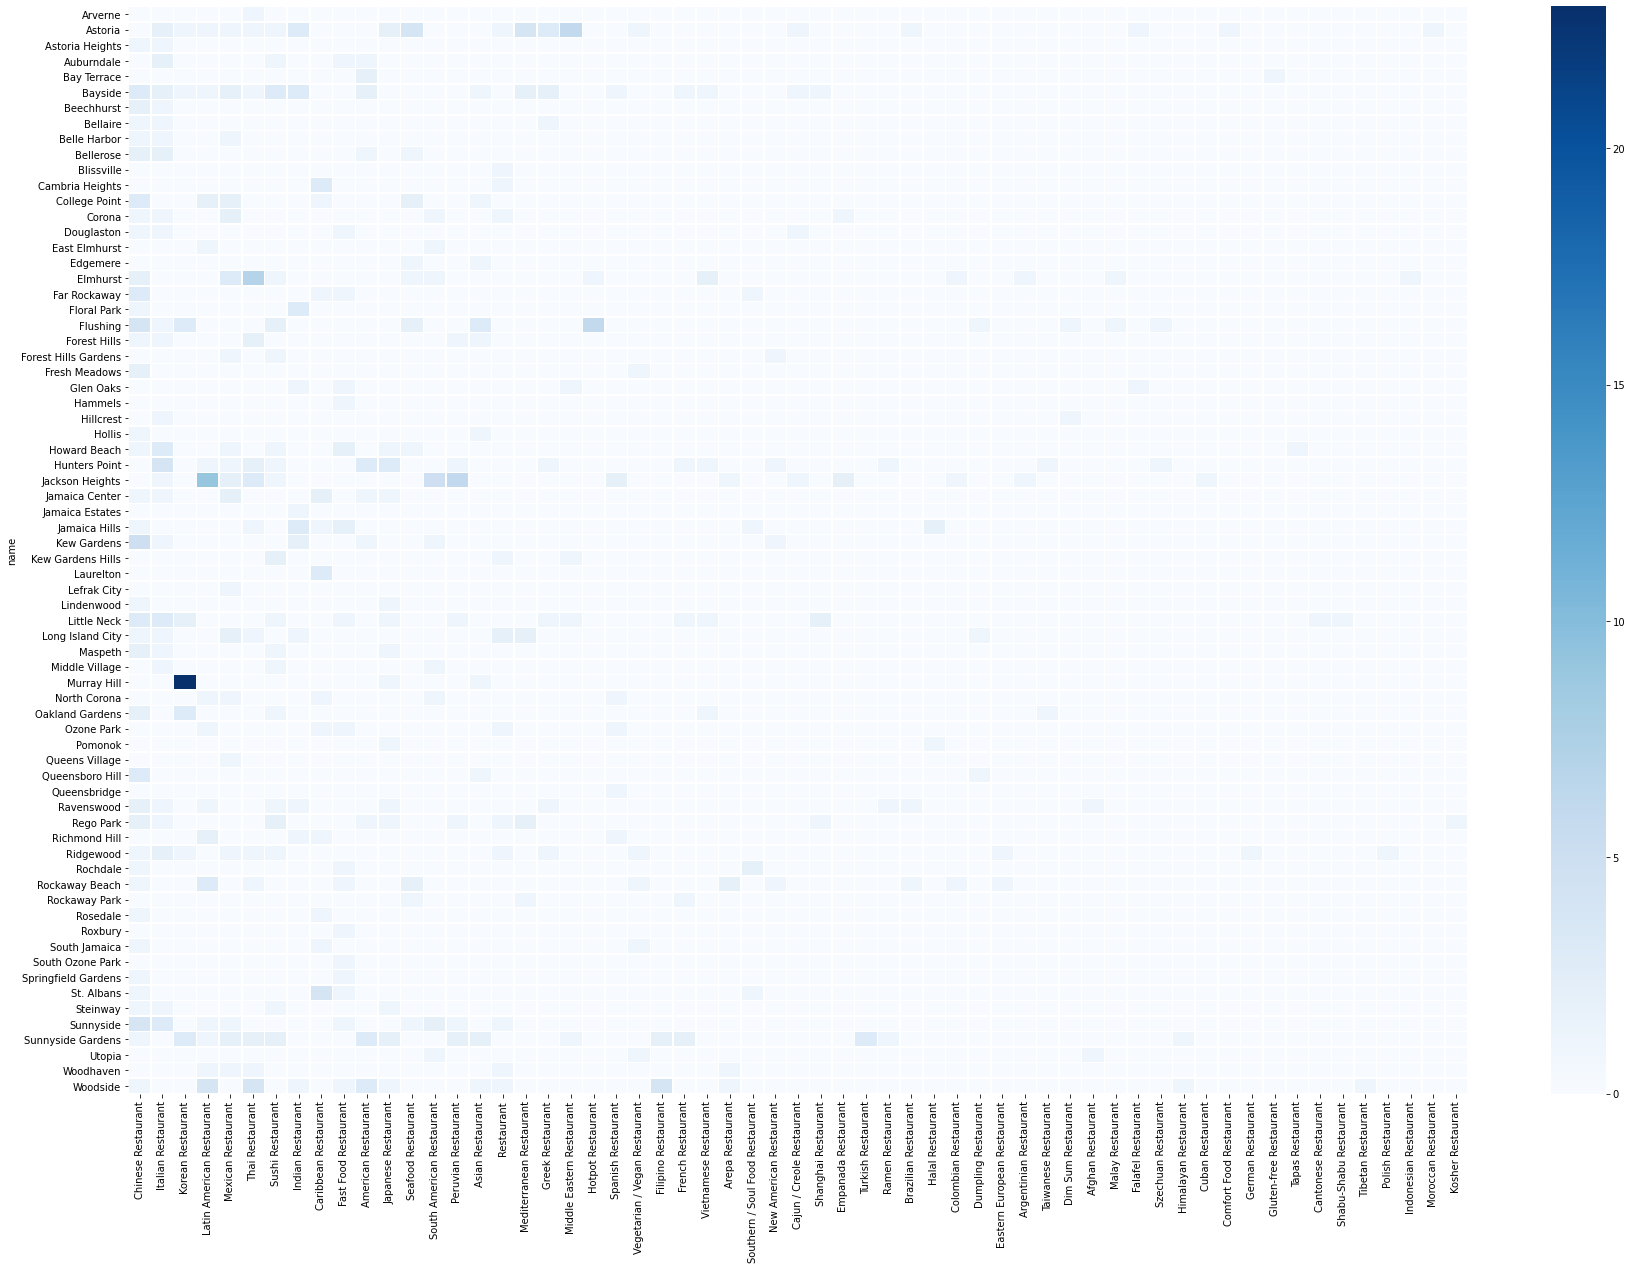

In [71]:
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(queens_rest,cmap="Blues", linewidths=0.5)

In [73]:
queens_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
5,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant
6,Astoria,40.768509,-73.915654,Al-sham Sweets and Pastries,40.768077,-73.911561,Middle Eastern Restaurant
10,Astoria,40.768509,-73.915654,The Gully,40.766719,-73.912410,Indian Restaurant
11,Astoria,40.768509,-73.915654,Duzan,40.768730,-73.911013,Falafel Restaurant


### Checkpoint 2 - Red Ocean Strategy - Visualize the Cluster of Italian and Chinese Restaurant in Manhattan
We are picking Italian and Chinese because based on our analysis above, they always appear in the TOP-5
And these two dishes are relatively easy to prepare and I am capable of doing it.

In [90]:
# Set up the map
map_ny = folium.Map(location=[manhattan_lat, manhattan_lng], zoom_start=13)

In [91]:
# Get the Chinese Restaurant
chinese_rest =  manhattan_venues[manhattan_venues['Venue Category']=='Chinese Restaurant']
italian_rest =  manhattan_venues[manhattan_venues['Venue Category']=='Italian Restaurant']

# add markers to map
for lat, lng, label in zip(chinese_rest['Venue Latitude'], chinese_rest['Venue Longitude'], chinese_rest['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#8631cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)

# add markers to map
for lat, lng, label in zip(italian_rest['Venue Latitude'], italian_rest['Venue Longitude'], italian_rest['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny) 
    
map_ny

### NEXT STEPS
as a next step for this Red Ocean Strategy, we should overlay the map above with the average rent price per area. This will help us to study which area is expected to have higher $